# Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH

# Библиотеки: [Python, Tensorflow]

## Libs

In [1]:
import os
import glob
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers

## Load ds

In [2]:
!wget http://www.nada.kth.se/cvap/actions/walking.zip
!wget http://www.nada.kth.se/cvap/actions/jogging.zip
!wget http://www.nada.kth.se/cvap/actions/running.zip
!wget http://www.nada.kth.se/cvap/actions/boxing.zip
!wget http://www.nada.kth.se/cvap/actions/handwaving.zip
!wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

!unzip walking.zip -d walking > /dev/null
!unzip jogging.zip -d jogging > /dev/null
!unzip running.zip -d running > /dev/null
!unzip boxing.zip -d boxing > /dev/null
!unzip handwaving.zip -d handwaving > /dev/null
!unzip handclapping.zip -d handclapping > /dev/null

--2021-06-23 12:49:31--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2021-06-23 12:49:31--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M   797KB/s    in 5m 1s   

2021-06-23 12:54:34 (787 KB/s) - ‘walking.zip’ saved [242442411/242442411]

--2021-06-23 12:54:34--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.se (www.nada.kth.s

## Prep dataset

In [3]:
classes = ['walking', 'jogging', 'running', 'boxing', 'handwaving', 'handclapping']
DATA_ROOT = './'

In [4]:
"""
get path to videos
"""

dataset = []
for cls in classes:
    videos = os.path.join(DATA_ROOT, cls, '*.avi')
    videos = glob.glob(videos)
    for v in videos:
        cls_idx = classes.index(cls)
        dataset.append([v, cls_idx])
        
print(len(dataset))
print(dataset[:5])

599
[['./walking/person08_walking_d4_uncomp.avi', 0], ['./walking/person08_walking_d1_uncomp.avi', 0], ['./walking/person11_walking_d1_uncomp.avi', 0], ['./walking/person12_walking_d3_uncomp.avi', 0], ['./walking/person06_walking_d3_uncomp.avi', 0]]


In [5]:
def get_video_arr(path):
    """
    get video array
    """
    videodata = cv2.VideoCapture(path)
    
    video_array = []
    while True:
        frame = videodata.read()
        if frame[0]:
            video_array.append(frame[1])
        else: 
            return np.array(video_array)

In [6]:
"""
shuffle and split videos: 9/1
"""

random.shuffle(dataset)

count = int(len(dataset) * 0.9)
train, test = dataset[:count], dataset[count:]

len(train), len(test)

(539, 60)

videodata shape: (500, 120, 160, 3)


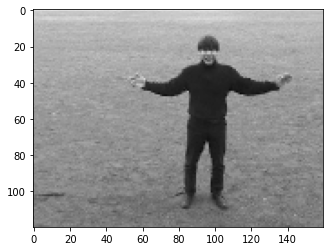

In [7]:
videodata = get_video_arr(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[25])

## Vied motion

motion shape: (499, 120, 160, 1)


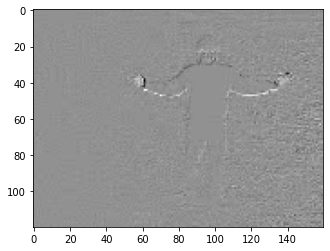

In [8]:
motion = np.mean(videodata[1:] - videodata[:-1], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[25, ..., 0], cmap='gray')

## CNN model

In [9]:
model = tf.keras.Sequential([
    layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    layers.MaxPool3D((1, 2, 2), padding='same'),
    layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    layers.MaxPool3D((1, 2, 2), padding='same'),
    layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    layers.MaxPool3D((1, 2, 2), padding='same'),
    layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    
    layers.GlobalAveragePooling3D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation=None),
])

In [10]:
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE)
)

writer = tf.summary.create_file_writer('logs/exp1')

## Training

Обучать будем на колабе, там видюха мощная)

In [11]:
def prep_to_model(path, lbl):
    """
    preperation data to model
    """
    videodata = get_video_arr(path)
    videodata = videodata.astype(np.float32) / 255.

    motion = np.mean(videodata[1:] - videodata[:-1], axis=3, keepdims=True)

    x = motion[None, ...]
    y = np.array(lbl)[None, ...]
    
    return x, y

In [12]:
%%time

EPOCHS = 5

train_loss = []
test_loss = []

for ep in range(EPOCHS):
    for i, (path, lbl) in enumerate(train):
        x, y = prep_to_model(path, lbl)
        train_loss_value = model.train_on_batch(x, y)
        
        if i % 32 == 0:
            path, lbl = random.choice(test)
            
            x, y = prep_to_model(path, lbl)
            test_loss_value = model.test_on_batch(x, y)
            
            train_loss.append(train_loss_value)
            test_loss.append(test_loss_value)
            
            print(f'[{ep}/{EPOCHS}][{i}/{len(train)}] Train loss = {train_loss_value} | Test loss = {test_loss_value}')

[0/5][0/539] Train loss = 1.7855768203735352 | Test loss = 1.8103468418121338
[0/5][32/539] Train loss = 1.80377197265625 | Test loss = 1.799965262413025
[0/5][64/539] Train loss = 1.7889198064804077 | Test loss = 1.7724252939224243
[0/5][96/539] Train loss = 1.8419710397720337 | Test loss = 1.7878739833831787
[0/5][128/539] Train loss = 1.3118829727172852 | Test loss = 1.7012336254119873
[0/5][160/539] Train loss = 1.7852966785430908 | Test loss = 1.4480363130569458
[0/5][192/539] Train loss = 1.2570159435272217 | Test loss = 1.8155608177185059
[0/5][224/539] Train loss = 1.409668207168579 | Test loss = 1.4187332391738892
[0/5][256/539] Train loss = 1.2525827884674072 | Test loss = 1.6150038242340088
[0/5][288/539] Train loss = 3.4397552013397217 | Test loss = 1.8162469863891602
[0/5][320/539] Train loss = 1.1271042823791504 | Test loss = 0.45868566632270813
[0/5][352/539] Train loss = 0.005039251875132322 | Test loss = 1.0458933115005493
[0/5][384/539] Train loss = 1.0329198837280273

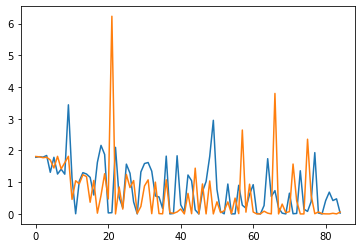

In [13]:
plt.plot(train_loss)
plt.plot(test_loss)

График получился адский - круто!)<br>
Попробуем результат на тесте

## Testing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


array([], dtype=int64)

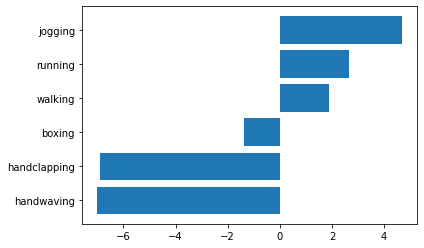

In [65]:
bars = plt.barh(m, p)

true_idx = np.where(m == cls_true)[0]
# if true_idx.size:
#   bars[true_idx[0]].set_color('g')
true_idx

True: walking
Pred: jogging



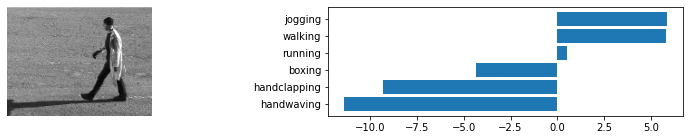

True: boxing
Pred: boxing



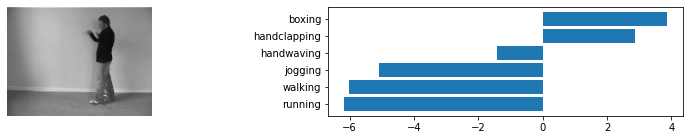

True: jogging
Pred: walking



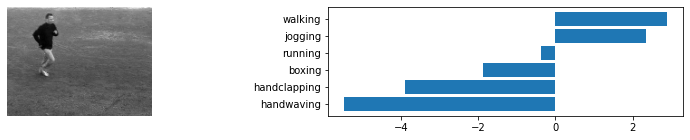

True: walking
Pred: walking



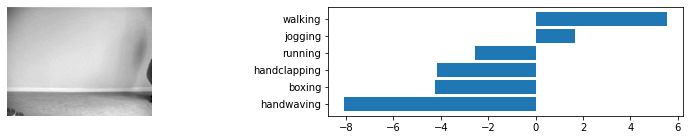

In [75]:
for i in range(4):
  fpath, cls_true = random.choice(test)
  motion = prep_to_model(fpath, cls_true)[0]

  prob = model(motion)
  prob = prob[0].numpy()

  pred = np.argmax(prob)

  print(f'True: {classes[cls_true]}\n',
        f'Pred: {classes[pred]}\n', sep='')

  plt.figure(figsize=(14, 2))
  
  plt.subplot(1, 2, 1)
  videodata = get_video_arr(fpath)
  plt.imshow(videodata[25, ..., 0], cmap='gray')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  motion_prob = sorted(zip(classes, prob), key=lambda mp: mp[1])
  m = np.array(motion_prob)[:, 0]
  p = np.array(motion_prob)[:, 1].astype(np.float32)
  bars = plt.barh(m, p)

  plt.show()

Видно, что модель справляется не плохо, даже есть спорные категории